In [5]:
# 基本的なライブラリ
import copy
import itertools
import pickle
import warnings

# config python file
import config
import functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# XAI
import shap
import xgboost as xgb
from imblearn import FunctionSampler

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト

# 機械学習アルゴリズム
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from tqdm import tqdm

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY
functions.fix_seed(SEED)

# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)
%matplotlib inline
plt.rcParams["font.size"] = 18

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced.pkl"
)

AttributeError: module 'config' has no attribute 'INDEX_MICROARRAY'

# predict test data & use SHAP

In [2]:
def plot_beeswarm(
    shap_values,
    max_display: int = 9,
    fig_title: str = "beeswarm",
    save_fig_path: str = None,
    save_fig_name: str = None,
    subgroup: str = None,
):
    plt.figure()
    shap.plots.beeswarm(
        shap_values, show=False, max_display=max_display, color_bar=False
    )
    plt.colorbar()
    if save_fig_path and save_fig_name and subgroup:
        functions.make_dir(save_fig_path)
        plt.title(fig_title)
        plt.tight_layout()
        plt.savefig(save_fig_path + save_fig_name)
    plt.show()


"""
def plot_permutation(
    shap_values,
    save_fig_path: str = None,
    save_fig_name: str = None,
    subgroup: str = None,
):
    show = False if (save_fig_path and save_fig_name and subgroup) else True
    shap.plots.bar(shap_values, show=show)
    if not show:
        functions.make_dir(save_fig_path)
        plt.title("subtype|{0}".format(subgroup))
        plt.tight_layout()
        plt.savefig(save_fig_path + save_fig_name)
    plt.show()
"""
pass

## Linear SVM

0it [00:00, ?it/s]

mrmr_std_smote
##################################################
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


acc_train   acc_val  f1_train  f1_val
classifier                                       
SVC            0.8875  0.545455  0.888889   0.375

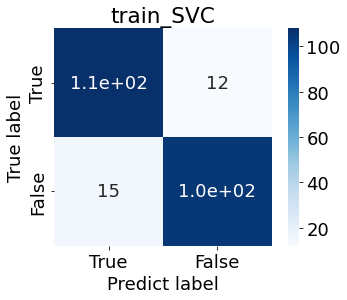

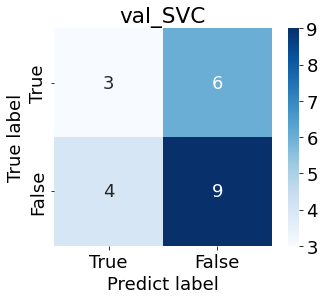

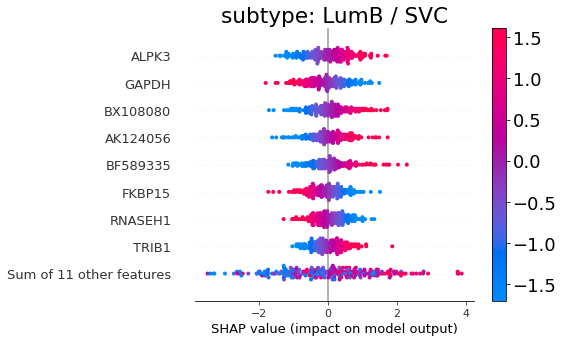

subgroup:  Her2


acc_train   acc_val  f1_train  f1_val
classifier                                       
SVC          0.973333  0.416667  0.974026     0.0

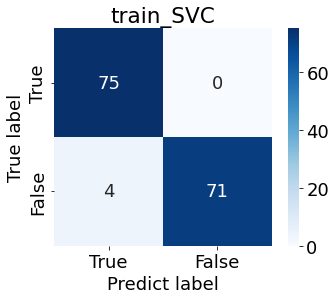

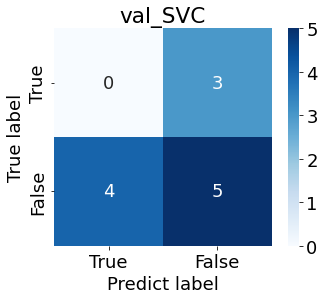

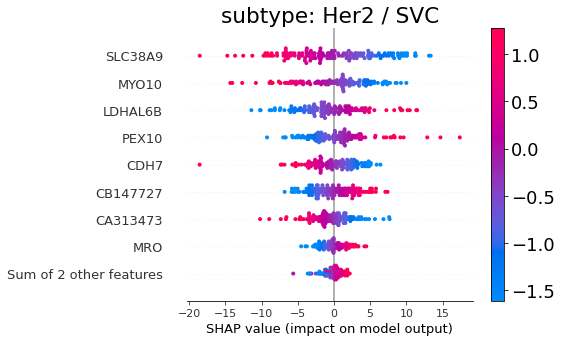

subgroup:  LumA


acc_train   acc_val  f1_train    f1_val
classifier                                         
SVC          0.850467  0.636364  0.853211  0.714286

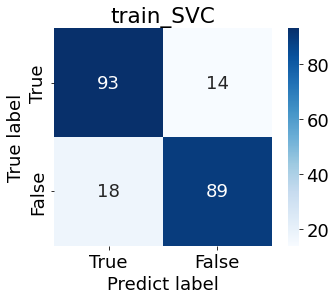

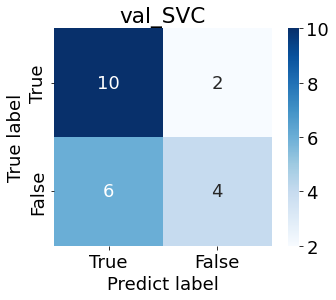

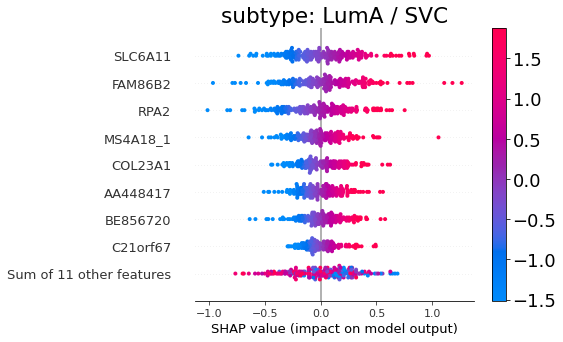

1it [00:01,  1.91s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


In [3]:
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )

    print(preprocess_order)
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("#####" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            clf = SVC(
                kernel="linear",
                random_state=SEED,
                class_weight="balanced",
            )
            print("subgroup: ", subgroup)

            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            try:
                _, _, list_train_val, list_test = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue

            X_train, y_train = list_train_val[0], list_train_val[1]
            X_test, y_test = list_test[0], list_test[1]

            tuning_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            tuning_file_name_params = "/params_{0}.pkl".format(subgroup)
            best_params = functions.pickle_load(
                tuning_file_path + tuning_file_name_params
            )
            params = {
                "C": best_params["C"],
                "kernel": "linear",
                "max_iter": 10000,
                "class_weight": "balanced",
                "random_state": SEED,
                "probability": True,
            }
            # clf.set_params(**params)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    classifiers=[clf],
                    plot=True,
                )
            )

            clf.set_params(**params)
            clf.fit(X_train, y_train)

            # load JS visualization code to notebook
            shap.initjs()
            save_fig_path = "{0}/{1}/{2}".format(
                config.FIGURES_EXPLAIN_RECURRENCE_DIR,
                preprocess_order,
                clf.__class__.__name__,
            )

            # beeswarm plot
            explainer = shap.Explainer(clf, X_train, feature_names=X_train.columns)
            shap_values = explainer(X_train)
            fig_title = "subtype: {0} / {1}".format(subgroup, clf.__class__.__name__)
            save_fig_name = "/beeswarm_{0}_{1}.png".format(
                subgroup, clf.__class__.__name__
            )
            plot_beeswarm(
                shap_values,
                fig_title=fig_title,
                save_fig_path=save_fig_path,
                save_fig_name=save_fig_name,
                subgroup=subgroup,
            )

## Logistic Regression

0it [00:00, ?it/s]

mrmr_std_smote
##################################################
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


acc_train   acc_val  f1_train  f1_val
classifier                                               
LogisticRegression   0.895833  0.545455  0.896266   0.375

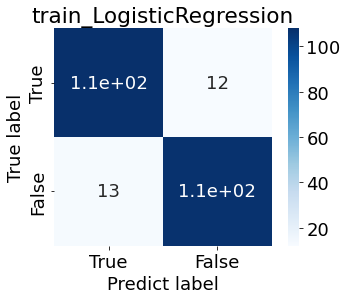

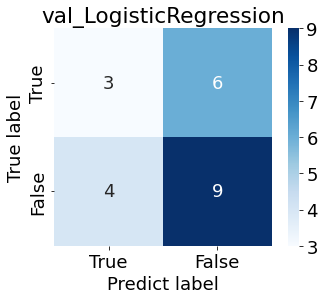

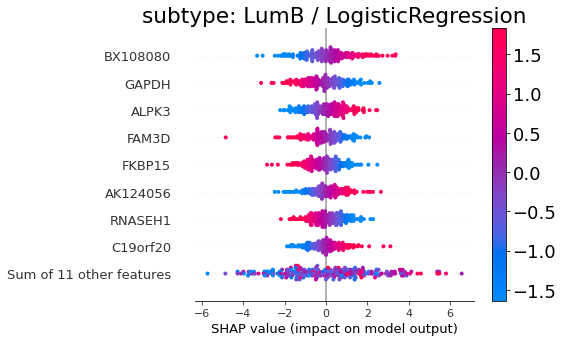

subgroup:  Her2


acc_train  acc_val  f1_train  f1_val
classifier                                              
LogisticRegression   0.973333      0.5  0.973684     0.0

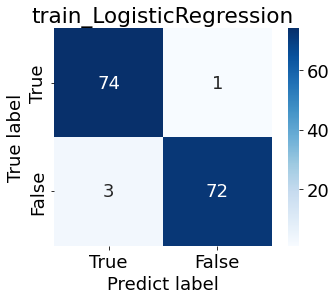

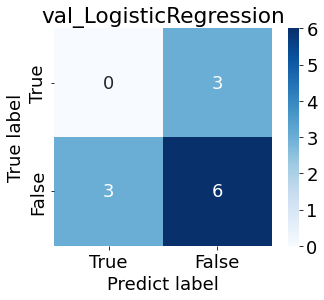

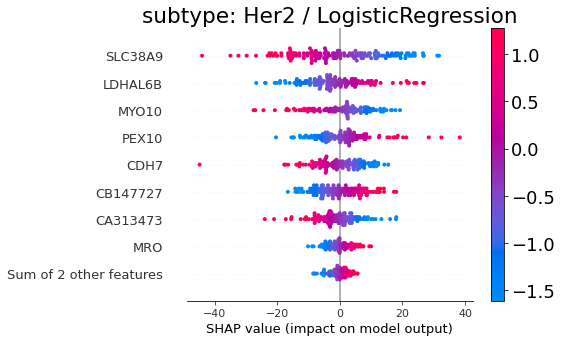

subgroup:  LumA


acc_train   acc_val  f1_train    f1_val
classifier                                                 
LogisticRegression   0.841121  0.590909  0.841121  0.689655

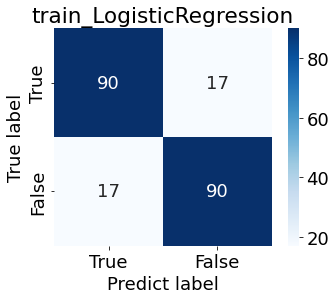

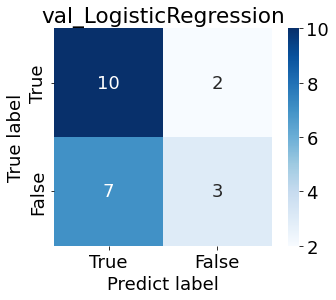

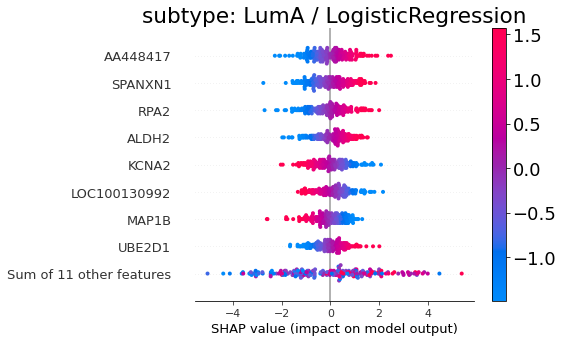

1it [00:01,  1.70s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


In [4]:
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )

    print(preprocess_order)
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("#####" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            clf = LogisticRegression()
            print("subgroup: ", subgroup)

            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            try:
                _, _, list_train_val, list_test = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue

            X_train, y_train = list_train_val[0], list_train_val[1]
            X_test, y_test = list_test[0], list_test[1]

            tuning_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            tuning_file_name_params = "/params_{0}.pkl".format(subgroup)
            best_params = functions.pickle_load(
                tuning_file_path + tuning_file_name_params
            )

            params = {
                "penalty": best_params["penalty"],
                "C": best_params["C"],
                "max_iter": 1000,
                "solver": "liblinear",
                "class_weight": "balanced",
                "random_state": SEED,
            }

            clf.set_params(**params)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    classifiers=[clf],
                    plot=True,
                )
            )

            clf.set_params(**params)
            clf.fit(X_train, y_train)

            # load JS visualization code to notebook
            shap.initjs()
            save_fig_path = "{0}/{1}/{2}".format(
                config.FIGURES_EXPLAIN_RECURRENCE_DIR,
                preprocess_order,
                clf.__class__.__name__,
            )

            # beeswarm plot
            explainer = shap.Explainer(clf, X_train, feature_names=X_train.columns)
            shap_values = explainer(X_train)
            fig_title = "subtype: {0} / {1}".format(subgroup, clf.__class__.__name__)
            save_fig_name = "/beeswarm_{0}_{1}.png".format(
                subgroup, clf.__class__.__name__
            )
            plot_beeswarm(
                shap_values,
                fig_title=fig_title,
                save_fig_path=save_fig_path,
                save_fig_name=save_fig_name,
                subgroup=subgroup,
            )

# Tree SHAP

## Random Forest

0it [00:00, ?it/s]

mrmr_std_smote
##################################################
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


acc_train   acc_val  f1_train  f1_val
classifier                                                   
RandomForestClassifier   0.991667  0.545455  0.991667   0.375

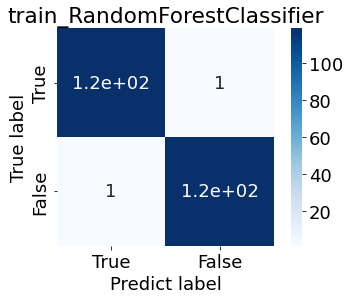

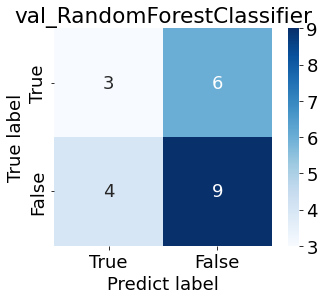

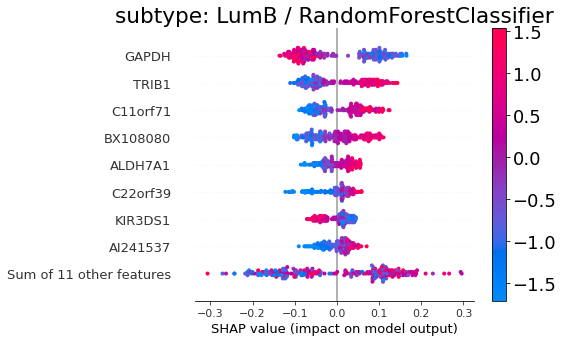

subgroup:  Her2


acc_train   acc_val  f1_train  f1_val
classifier                                                   
RandomForestClassifier        1.0  0.666667       1.0     0.0

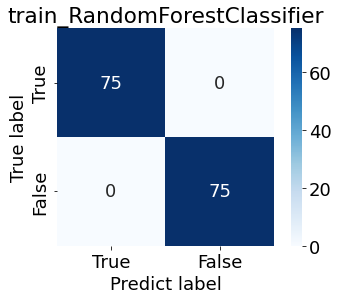

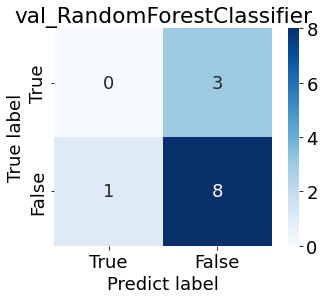

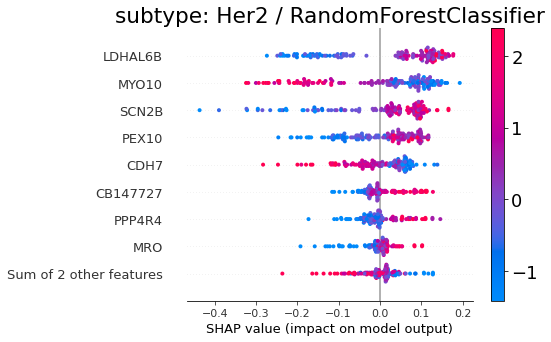

subgroup:  LumA


acc_train   acc_val  f1_train    f1_val
classifier                                                     
RandomForestClassifier        1.0  0.636364       1.0  0.666667

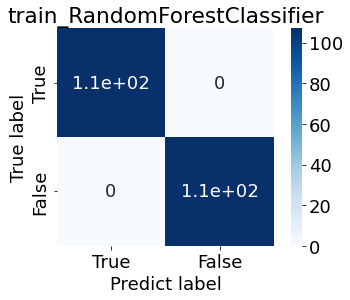

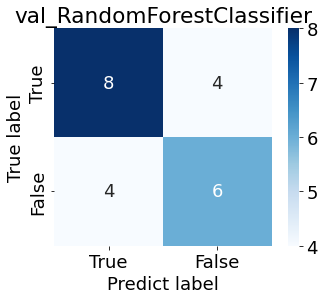

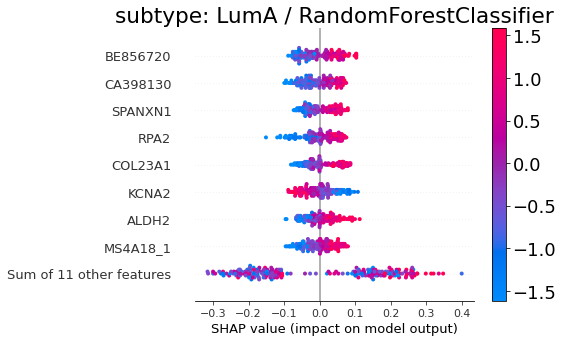

1it [00:06,  6.43s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


In [5]:
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )

    print(preprocess_order)
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("#####" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            clf = RandomForestClassifier()
            print("subgroup: ", subgroup)

            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            try:
                _, _, list_train_val, list_test = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue

            X_train, y_train = list_train_val[0], list_train_val[1]
            X_test, y_test = list_test[0], list_test[1]
            tuning_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            tuning_file_name_params = "/params_{0}.pkl".format(subgroup)
            best_params = functions.pickle_load(
                tuning_file_path + tuning_file_name_params
            )

            params = {
                "n_estimators": best_params["n_estimators"],
                "max_depth": best_params["max_depth"],
                "max_leaf_nodes": best_params["max_leaf_nodes"],
                "class_weight": "balanced",
                "random_state": SEED,
            }
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    classifiers=[clf.set_params(**params)],
                    plot=True,
                )
            )

            clf.set_params(**params)
            clf.fit(X_train, y_train)

            # load JS visualization code to notebook
            shap.initjs()
            save_fig_path = "{0}/{1}/{2}".format(
                config.FIGURES_EXPLAIN_RECURRENCE_DIR,
                preprocess_order,
                clf.__class__.__name__,
            )

            # beeswarm plot
            explainer = shap.TreeExplainer(clf)
            # to plot beeswarm using RF
            # https://github.com/slundberg/shap/issues/1460#issuecomment-946717889
            shap_values = explainer(X_train)
            shap_values_cp = copy.deepcopy(shap_values)
            shap_values_cp.values = shap_values_cp.values[:, :, 1]
            shap_values_cp.base_values = shap_values_cp.base_values[:, 1]
            fig_title = "subtype: {0} / {1}".format(subgroup, clf.__class__.__name__)
            save_fig_name = "/beeswarm_{0}_{1}.png".format(
                subgroup, clf.__class__.__name__
            )
            plot_beeswarm(
                shap_values_cp,
                fig_title=fig_title,
                save_fig_path=save_fig_path,
                save_fig_name=save_fig_name,
                subgroup=subgroup,
            )

# Kernel SHAP

## kNN

In [ ]:
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )

    print(preprocess_order)
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("#####" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            clf = KNeighborsClassifier()
            print("subgroup: ", subgroup)

            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            try:
                _, _, list_train_val, list_test = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue

            X_train, y_train = list_train_val[0], list_train_val[1]
            X_test, y_test = list_test[0], list_test[1]

            tuning_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            tuning_file_name_params = "/params_{0}.pkl".format(subgroup)
            best_params = functions.pickle_load(
                tuning_file_path + tuning_file_name_params
            )

            params = {
                "n_neighbors": best_params["n_neighbors"],
                "weights": best_params["weights"],
                "algorithm": best_params["algorithm"],
                "leaf_size": best_params["leaf_size"],
                "p": best_params["p"],
            }
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    classifier_names=[clf.__class__.__name__],
                    classifiers=[clf.set_params(**params)],
                    # plot=True,
                )
            )

            # SHAP
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            # load JS visualization code to notebook
            shap.initjs()
            # Create object that can calculate shap values
            explainer = shap.KernelExplainer(
                clf.predict_proba, X_train, feature_names=X_train.columns
            )
            shap_values = explainer.shap_values(X_train)
            shap_explanation = shap.Explanation(
                shap_values, X_train, feature_names=X_train.columns
            )
            shap.plots.beeswarm(shap_explanation, show=False)
            # save fig
            save_fig_path = "{0}/{1}/{2}".format(
                config.FIGURES_EXPLAIN_RECURRENCE_DIR,
                preprocess_order,
                clf.__class__.__name__,
            )
            save_fig_name = "/beeswarm_{0}.png".format(subgroup)
            functions.make_dir(save_fig_path)
            plt.title("SHAP value plot (subtype is {0})".format(subgroup))
            plt.tight_layout()
            plt.savefig(save_fig_path + save_fig_name)
            plt.show()

In [20]:

_model_pipeline = functions.pickle_load(config.INTERIM_PREPROCESSED_RECURRENCE_DIR+"/CLAUDIN_SUBTYPE/Her2/preprocess4classification_1/val_set/test/preprocess_pipeline.pkl")
_estimator = _model_pipeline[-1]
print(_estimator)

AttributeError: Can't get attribute 'StandardScalerAsDataFrame' on <module '__main__'>

In [ ]:
cd